In [2]:
%load_ext autoreload
%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg
%matplotlib inline
import jax
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch
plt.style.use('ggplot')

/mnt/c/Users/Habush/PycharmProjects/bnn_bg


# Continous Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [11]:
def npdensity1(z):
    z = jnp.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = jnp.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - jnp.log(exp1 + exp2)
    return jnp.exp(-u)

def npdensity2(z):
    z = z.reshape(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


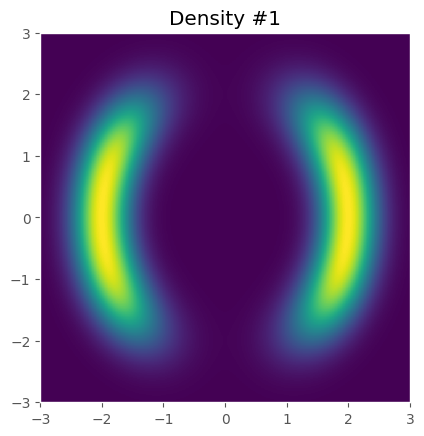

In [3]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

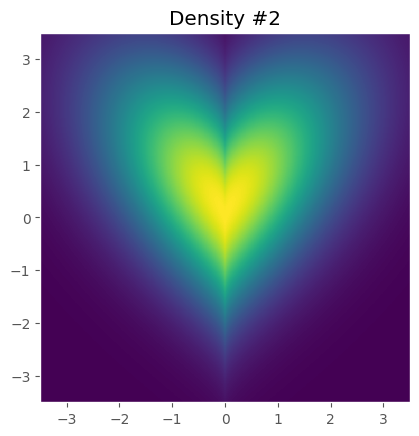

In [4]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz. 

In [14]:
def potential1(z):
    z = z.reshape(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = jnp.linalg.norm(z, axis=1)
    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - jnp.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.reshape(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

In [15]:
import optax
from core.sgmcmc import *

def unadjusted_langevin_algorithm(seed, potential, n_samples=10000, step=0.1):
    rng = jax.random.PRNGKey(seed)
    init_key, key = jax.random.split(rng, 2)
    burn_in = 1000
    Z0 = jax.random.normal(init_key, shape=(1, 2))
    Zi = Z0
    step_fn = optax.constant_schedule(step)
    sampler = sgld_gradient_update(step_fn, 
                                   seed, 0.9, get_rmsprop_preconditioner())
    
    
    
    
    @jax.jit
    def update(key, z, opt_state):
        grad = jax.grad(lambda t: -jnp.mean(potential(t)))(z)
        updates, opt_state = sampler.update(grad, opt_state, key)
        z = optax.apply_updates(z, updates)
        # n = jax.random.normal(key, shape=z.shape)
        # z = z - step * grad + jnp.sqrt(2*step)*n
        return z, opt_state
    
    
    opt_state = sampler.init(Z0)
    samples = []
    
    for i in tqdm(range(n_samples + burn_in)):
        _, key = jax.random.split(key, 2)
        Zi, opt_state = update(key, Zi, opt_state)
        samples.append(Zi)
    return np.concatenate(samples, 0)[burn_in:]

2023-12-13 15:23:19.969573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
seed = 42
samples1 = unadjusted_langevin_algorithm(seed, potential1, n_samples=50000)
samples2 = unadjusted_langevin_algorithm(seed, potential2, n_samples=50000)

/tmp/ipykernel_51786/3629213958.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/51000 [00:00<?, ?it/s]

  0%|          | 0/51000 [00:00<?, ?it/s]

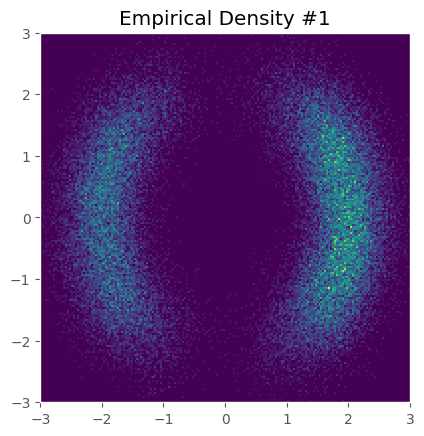

In [17]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

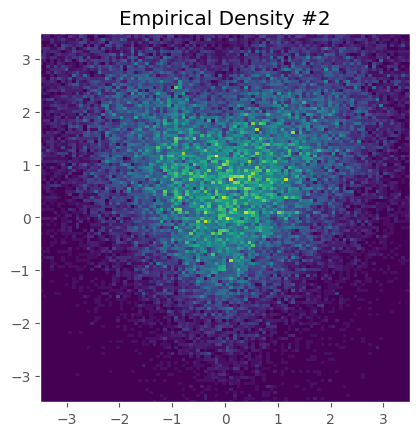

In [18]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

In [56]:
# def unadjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
#     burn_in = 10000
#     Z0 = torch.randn(1, 2)
#     Zi = Z0
#     samples = []
#     for i in tqdm(range(n_samples + burn_in)):
#         Zi.requires_grad_()
#         u = potential(Zi).mean()
#         grad = torch.autograd.grad(u, Zi)[0]
#         Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
#         samples.append(Zi.detach().numpy())
#     return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

## Metropolis-adjusted Langevin Algorithm (MALA)

New samples are proposed using the Euler-Maruyama scheme as before, but are accepted/rejected using the Metropolis-Hastings algorithm, i.e., the acceptance propability is given by

$$\alpha = \min \left\{1, \frac{p(x_{k+1})Q(x_k|x_{k+1})}{p(x_{k})Q(x_{k+1}|x_{k})}\right\}$$

where 

$$Q(x'|x) \propto \exp\left(-\frac{1}{4\gamma}\|x' - x + \gamma\nabla U(x)\|^2\right)$$

In [19]:
def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)
    
def metropolis_adjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

In [20]:
samples1 = metropolis_adjusted_langevin_algorithm(potential1)
samples2 = metropolis_adjusted_langevin_algorithm(potential2)

/tmp/ipykernel_51786/3557040649.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(range(n_samples + burn_in))


  0%|          | 0/110000 [00:00<?, ?it/s]

TypeError: Cannot interpret 'torch.float32' as a data type

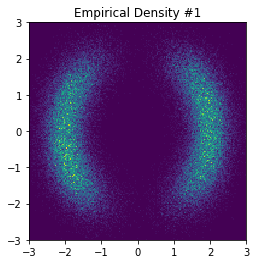

In [52]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

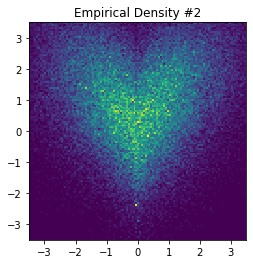

In [53]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-Hastings Algorithm for comparison

In [54]:
def metropolis_hastings(target_density, size=100000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [55]:
samples1 = metropolis_hastings(npdensity1)
samples2 = metropolis_hastings(npdensity2)

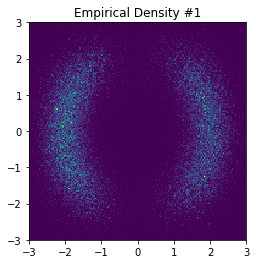

In [56]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

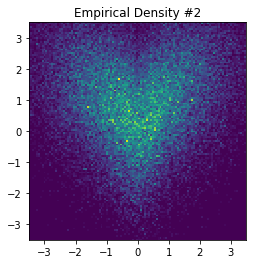

In [57]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

# Discrete Unadjusted Langevin Algorithm (DULA) 

### Ising model

In [3]:
%autoreload

import igraph as ig
import torch
import tensorflow_probability.substrates.jax as tfp
from core.sgmcmc import *

tfd = tfp.distributions

def construct_ising_model(rng, dim, init_sigma=0.15,  init_bias=0., lattice_dim=2, temp=2.0):
    g = ig.Graph.Lattice(dim=[dim]*lattice_dim, circular=True)
    A = np.asarray(g.get_adjacency().data)
    J = init_sigma*A
    bias = jnp.ones((dim**lattice_dim), ) * init_bias
    
    init_dist = tfd.Bernoulli(logits=2*bias)
    
    x0 = init_dist.sample(seed=rng)*1.0
    
    def log_prob_fn(x):     
        # x = (2*x) - 1
        # xg = x @ J
        # xgx = jnp.sum(xg * x, axis=-1)
        # b = jnp.sum(bias[None, :]*x, axis=-1)
        # return jnp.sum(xgx + b)
        xgx = x.T @ J @ x
        b = jnp.sum(bias @ x)
        return (xgx + b) / temp
        
    return log_prob_fn, x0

def get_discrete_kernel(seed, log_prob_fn, step_size_fn, optimizer_fn, 
                        x0, mh=False, 
                        temp=1.0, preconditioner=None, 
                        cat=False, dim=None, num_cls=None):
    
    if cat:
        sampler = optimizer_fn(step_size_fn, seed, dim, num_cls,
                              preconditioner=preconditioner, mh=mh, temp=temp)
    else:
        sampler = optimizer_fn(step_size_fn, seed, 
                          preconditioner=preconditioner, mh=mh, temp=temp)
    opt_state = sampler.init(x0)
    
    def step(x, opt_state):
        x, opt_state, acc_prob = sampler.update(x, log_prob_fn, opt_state)
        return x, opt_state, {"acc_prob": acc_prob}
    
    return step, opt_state

2023-12-13 18:51:38.260271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
init_sigma, init_bias = 0.1, 0.2
dim = 4
gt_mean_dir = "/mnt/c/Users/Habush/PycharmProjects/discrete-langevin/figs/ising_sample"
gt_mean = torch.load("{}/gt_mean_dim{}_sigma{}_bias{}.pt".format(gt_mean_dir, dim, init_sigma, init_bias)).numpy()

In [5]:
def get_log_rmse(x,gt_mean):
    x = 2. * x - 1.
    x2 = jnp.sqrt(jnp.mean((x-gt_mean) ** 2))
    return jnp.log(x2)

def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = np.array(tfp.mcmc.effective_sample_size(c))
    cv[np.isnan(cv)] = 1.
    return cv

In [12]:
import time

seed = 42

n_steps = 10000
burn_in = 0.1
step_size = 0.7
times = []
hops = []
chain = []
cur_time = 0.
time_lst = []
rmses = []

viz_every, print_very = 1000, 10

rng = jax.random.PRNGKey(seed)
init_rng, key = jax.random.split(rng, 2)

ising_prob_fn, x0 = construct_ising_model(init_rng, dim, init_sigma, init_bias, )
x = x0
mean = jnp.zeros_like(x)

kernel, opt_state = get_discrete_kernel(seed, ising_prob_fn, 
                                        optax.constant_schedule(step_size), 
                                        disc_bin_sgld_gradient_update, x, 
                                        mh=False, temp=2.0)

kernel = jax.jit(kernel)

for i in tqdm(range(n_steps)):
    _, key = jax.random.split(key, 2)
    st = time.time()
    xhat, opt_state, accept_prob = kernel(x, opt_state)

    cur_time += time.time() - st
    # compute hamming dist
    cur_hops = jnp.mean(jnp.sum(x != xhat, axis=-1))

    # update trajectory
    x = xhat
    mean = mean + x
    if i % print_very:
        times.append(cur_time)
        hops.append(cur_hops)
        time_lst.append(cur_time)
        rmse = get_log_rmse(mean / (i+1), gt_mean)
        rmses.append(rmse)

    chain.append(x)
chain = np.array(chain)

/tmp/ipykernel_12886/4267944903.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_steps)):


  0%|          | 0/10000 [00:00<?, ?it/s]

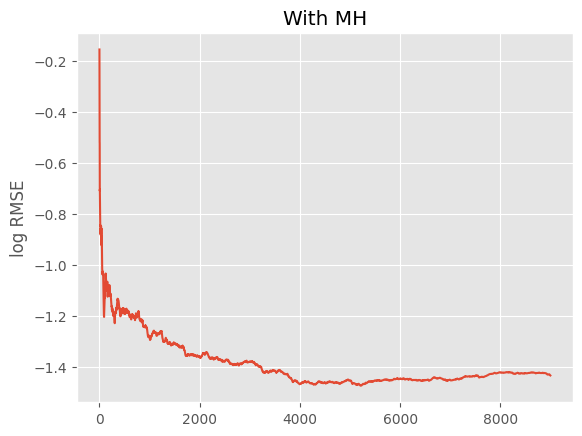

In [11]:
plt.title("With MH")
plt.plot(rmses)
plt.ylabel("log RMSE")
plt.show()

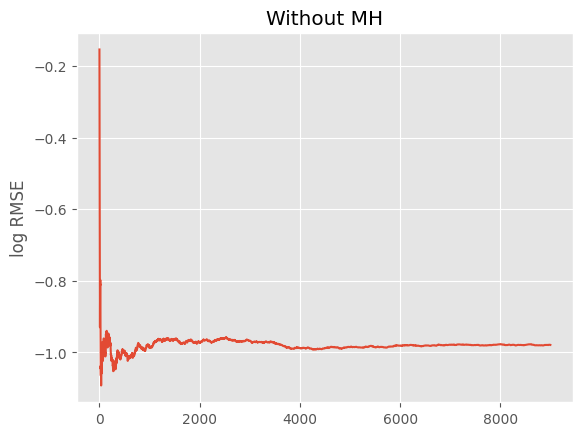

In [13]:
plt.title("Without MH")
plt.plot(rmses)
plt.ylabel("log RMSE")
plt.show()

In [34]:
ess = get_ess(np.array(chain), burn_in)
print("ess = {} +/- {}".format(np.mean(ess), np.std(ess)))

ess = 2380.767822265625 +/- 152.58273315429688


In [21]:
ess = get_ess(np.array(chain), burn_in)
print("ess = {} +/- {}".format(np.mean(ess), np.std(ess)))

ess = 1310.407958984375 +/- 113.19490814208984


### Categorical Distribution

In [14]:
%autoreload

import igraph as ig
import tensorflow_probability.substrates.jax as tfp
# import torch
from core.sgmcmc import *

tfd = tfp.distributions

def get_discrete_kernel(seed, log_prob_fn, step_size_fn, optimizer_fn, 
                        x0, mh=False, 
                        temp=1.0, preconditioner=None, 
                        cat=False, dim=None, num_cls=None):
    
    if cat:
        sampler = optimizer_fn(step_size_fn, seed, dim, num_cls,
                              preconditioner=preconditioner, mh=mh, temp=temp)
    else:
        sampler = optimizer_fn(step_size_fn, seed, 
                          preconditioner=preconditioner, mh=mh, temp=temp)
    opt_state = sampler.init(x0)
    
    def step(x, opt_state):
        x, opt_state, accept_probs = sampler.update(x, log_prob_fn, opt_state)
        return x, opt_state, accept_probs
    
    return step, opt_state

In [15]:
%autoreload
from core.sgmcmc import *
from itertools import product
def construct_cat_dist(rng, data_dim, num_cls):
    
    prob_mat = jax.random.normal(rng, shape=(data_dim, num_cls))
    
    @jax.jit
    def log_prob(x):
       ### get log probability for state x
       ### shape of x: (batch_size, data_dim, num_cls); x must be a one-hot vector
       ### the log probability is (prob(x1) + prob(x3) + prob(x5) ... +prob(2k+1)) * (prob(x2) + prob(x4) + prob(2k)) 
       
       odd_prob = prob_mat[0::2, :]
       even_prob = prob_mat[1::2, :]
       
       odd_part = odd_prob[None, :, :] * x[:, 0::2, :]
       even_part = even_prob[None, :, :] * x[:, 1::2, :]
        
       odd_part = odd_part.reshape(odd_part.shape[0], -1).sum(axis=1) 
       even_part = even_part.reshape(even_part.shape[0], -1).sum(axis=1)
       
       return jnp.sum(odd_part - even_part)
    
    def get_groundtruth_prob():
        
        classes = [i for i in range(num_cls)]
        probs = []
        for comb in product(classes, repeat=data_dim):
            cur_state = np.zeros((1, data_dim, num_cls))
            cur_state[:, np.arange(data_dim), comb] = 1.
            log_p = log_prob(cur_state)
            print("Category: ", comb)
            probs.append(np.exp(log_p))
            
        probs = np.array(probs)
        print("Ground-Truth Distribution:\n", probs/np.sum(probs))
        
    get_groundtruth_prob()
    
    return log_prob

def x_to_index(x, data_dim, num_cls):
    index = np.zeros_like(x)
    for i in range(data_dim):
        index[:, i] = num_cls**(data_dim-i-1)
    index = index * x
    index = index.sum(axis=1)
    #print(x)
    #print(index)
    return index

In [16]:
seed = 0
rng = jax.random.PRNGKey(seed)
data_dim = 2
num_cls  = 3
n = 1
log_prob_fn = construct_cat_dist(rng, data_dim, num_cls)
n_steps = 10000
step_size = 0.2
temp = 2.

init_key, key = jax.random.split(rng, 2)

x = jax.random.randint(init_key, minval=0, maxval=num_cls, 
                       shape=(n, data_dim))
frequency = np.zeros((n, num_cls**data_dim))

kernel, opt_state = get_discrete_kernel(seed, log_prob_fn, 
                             optax.constant_schedule(step_size), 
                             disc_cat_sgld_gradient_update, x, temp=temp, cat=True, 
                             dim=data_dim, num_cls=num_cls, mh=True)

kernel = jax.jit(kernel)

accept_probs = []

for i in tqdm(range(n_steps)):
    _, key = jax.random.split(key, 2)
    x, opt_state, mh_info = kernel(x, opt_state)
    accept_probs.append(mh_info)
    index = x_to_index(jnp.int32(x), data_dim, num_cls)
    # print(index)
    for i in range(n):
        frequency[i][index[i]] += 1


print('Empirical Frequency from Sampler:\n', frequency/frequency.sum())

Category:  (0, 0)
Category:  (0, 1)
Category:  (0, 2)
Category:  (1, 0)
Category:  (1, 1)
Category:  (1, 2)
Category:  (2, 0)
Category:  (2, 1)
Category:  (2, 2)
Ground-Truth Distribution:
 [0.04640172 0.12671317 0.1819707  0.01065629 0.02910004 0.04179009
 0.07361957 0.20103928 0.2887092 ]


/tmp/ipykernel_12886/1950063476.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_steps)):


  0%|          | 0/10000 [00:00<?, ?it/s]

Empirical Frequency from Sampler:
 [[0.0451 0.103  0.1418 0.0125 0.0257 0.0529 0.1149 0.2431 0.261 ]]


In [18]:
accept_probs = np.array(accept_probs)
accept_probs.shape

(10000,)